In [1]:
import sklearn

# Common imports
import numpy as np
import pandas as pd
import os
import seaborn as sns
sns.set(style="darkgrid")
import xgboost
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from scipy.ndimage.interpolation import shift
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from pandas.plotting import scatter_matrix
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import expon, reciprocal, randint
from sklearn.metrics import roc_curve, auc, precision_recall_curve, precision_score , recall_score, f1_score

np.random.seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings('ignore')

import itertools

In [2]:
TITANIC_PATH = os.path.join("datasets", "titanic")
os.chdir("C:\\Users\\User\\Hands-on ML")
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

# 1 Exploratory Data Analysis

In [3]:
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")
all_data = pd.concat([train_data, test_data], sort=True).reset_index(drop=True)

y_train = train_data["Survived"]

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
# No dublicates
dublicated_rows = train_data[train_data.duplicated()]
dublicated_rows

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [8]:
# No dublicates
dublicated_rows = test_data[test_data.duplicated()]
dublicated_rows

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


## 1.1 Missing values

Age na shall be filled differently based on Sex and Pclass

In [9]:
age_by_pclass_sex = train_data.groupby(['Sex', 'Pclass']).median()['Age']
for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(train_data['Age'].median()))

Median age of Pclass 1 females: 35.0
Median age of Pclass 1 males: 40.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 30.0
Median age of Pclass 3 females: 21.5
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


Fare na shall be filled based on Pclass and family size

In [10]:
test_data[test_data['Fare'].isnull()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S


The following methods will be used to modify data considering missing values

In [11]:
def fill_age(X):
    X["Age"] = X.groupby(["Sex", "Pclass"])["Age"].apply(lambda x : x.fillna(x.median()))
    return X

# The missing data correspond to S
def fill_embarked(X):
    X['Embarked'] = X['Embarked'].fillna('S')
    return X

def fill_fare(X):
    X["Fare"] = X.groupby(['Pclass', 'Parch', 'SibSp'])["Fare"].apply(lambda x : x.fillna(x.median()))
    return X

In [12]:
missing_values_pipeline = Pipeline([  
    ("fill_age",  FunctionTransformer(fill_age)),
    ("fill_embarked",  FunctionTransformer(fill_embarked)),
    ("fill_fare",  FunctionTransformer(fill_fare))
    ])

In [13]:
train_data = missing_values_pipeline.fit_transform(train_data)
test_data = missing_values_pipeline.fit_transform(test_data)

## 1.2 Correlations

In [14]:
corr_matrix = train_data.corr()

In [15]:
corr_matrix["Survived"].abs().sort_values(ascending=False).drop("Survived")

Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.059579
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

In [16]:
corr_matrix["Age"].abs().sort_values(ascending=False).drop("Age")

Pclass         0.413583
SibSp          0.249854
Parch          0.175526
Fare           0.122692
Survived       0.059579
PassengerId    0.039033
Name: Age, dtype: float64

In [17]:
corr_matrix["Fare"].abs().sort_values(ascending=False).drop("Fare")

Pclass         0.549500
Survived       0.257307
Parch          0.216225
SibSp          0.159651
Age            0.122692
PassengerId    0.012658
Name: Fare, dtype: float64

In [18]:
corr_matrix["Pclass"].abs().sort_values(ascending=False).drop("Pclass")

Fare           0.549500
Age            0.413583
Survived       0.338481
SibSp          0.083081
PassengerId    0.035144
Parch          0.018443
Name: Pclass, dtype: float64

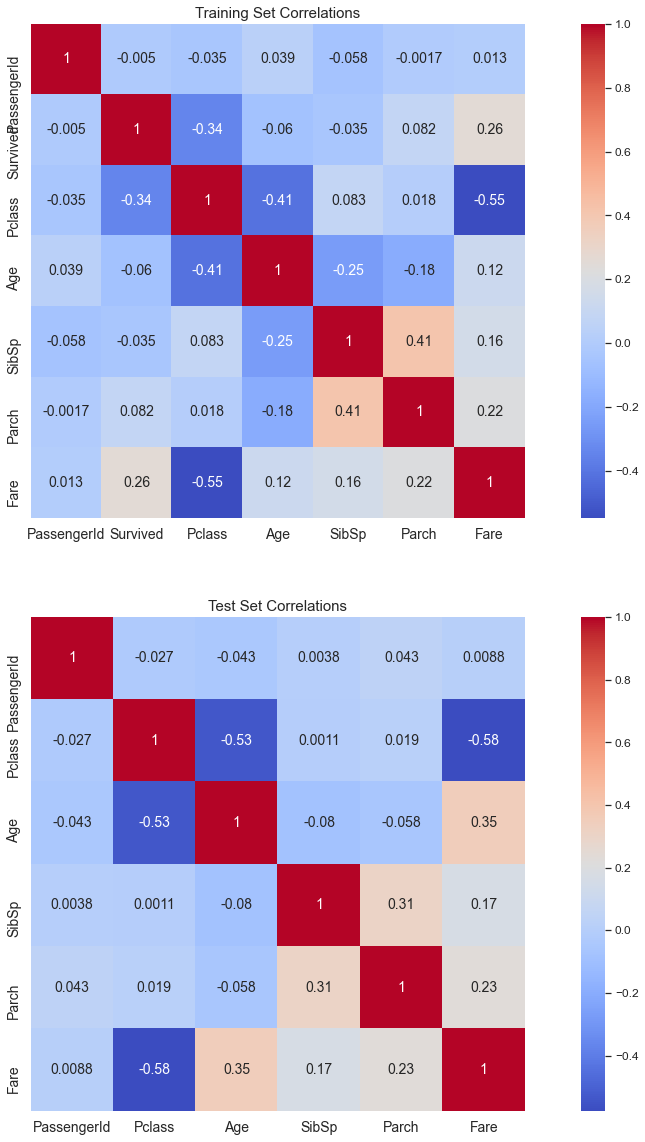

In [19]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(train_data.corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(test_data.corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

## 1.3 Target Distribution in Features

Both of the continuous features (Age and Fare) have good split points and spikes for a decision tree to learn. One potential problem for both features is, the distribution has more spikes and bumps in training set, but it is smoother in test set. Model may not be able to generalize to test set because of this reason.

- Distribution of Age feature clearly shows that children younger than 15 has a higher survival rate than any of the other age groups
- In distribution of Fare feature, the survival rate is higher on distribution tails. The distribution also has positive skew because of the extremely large outliers

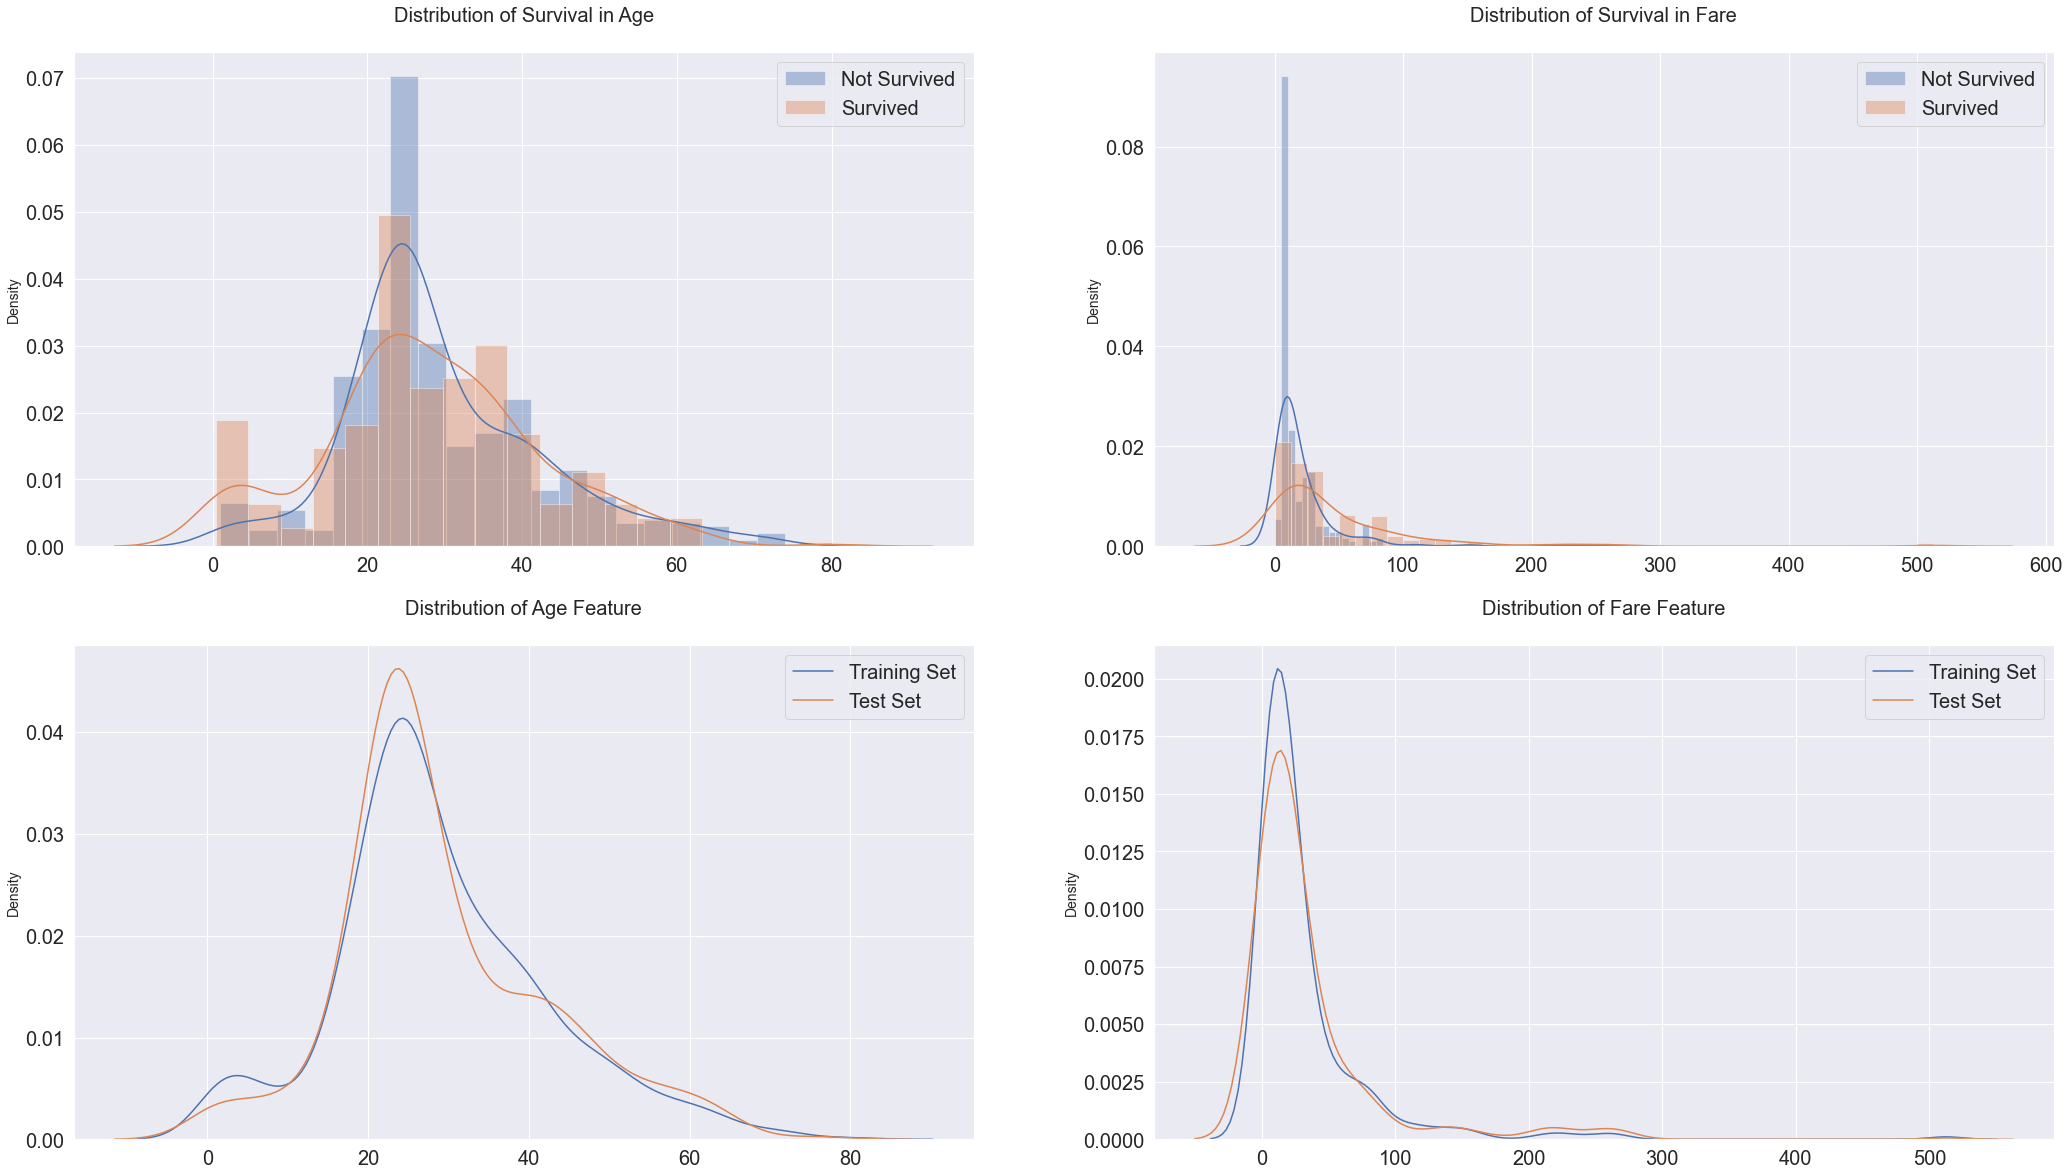

In [20]:
cont_features = ['Age', 'Fare']
surv = train_data['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(train_data[~surv][feature], label='Not Survived', hist=True, ax=axs[0][i])
    sns.distplot(train_data[surv][feature], label='Survived', hist=True, ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(train_data[feature], label='Training Set', hist=False, ax=axs[1][i])
    sns.distplot(test_data[feature], label='Test Set', hist=False, ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

Every categorical feature has at least one class with high mortality rate. Those classes are very helpful to predict whether the passenger is a survivor or victim. Best categorical features are Pclass and Sex because they have the most homogenous distributions.

- Passengers boarded from Southampton has a lower survival rate unlike other ports. More than half of the passengers boarded from Cherbourg had survived. This observation could be related to Pclass feature
- Parch and SibSp features show that passengers with only one family member has a higher survival rate

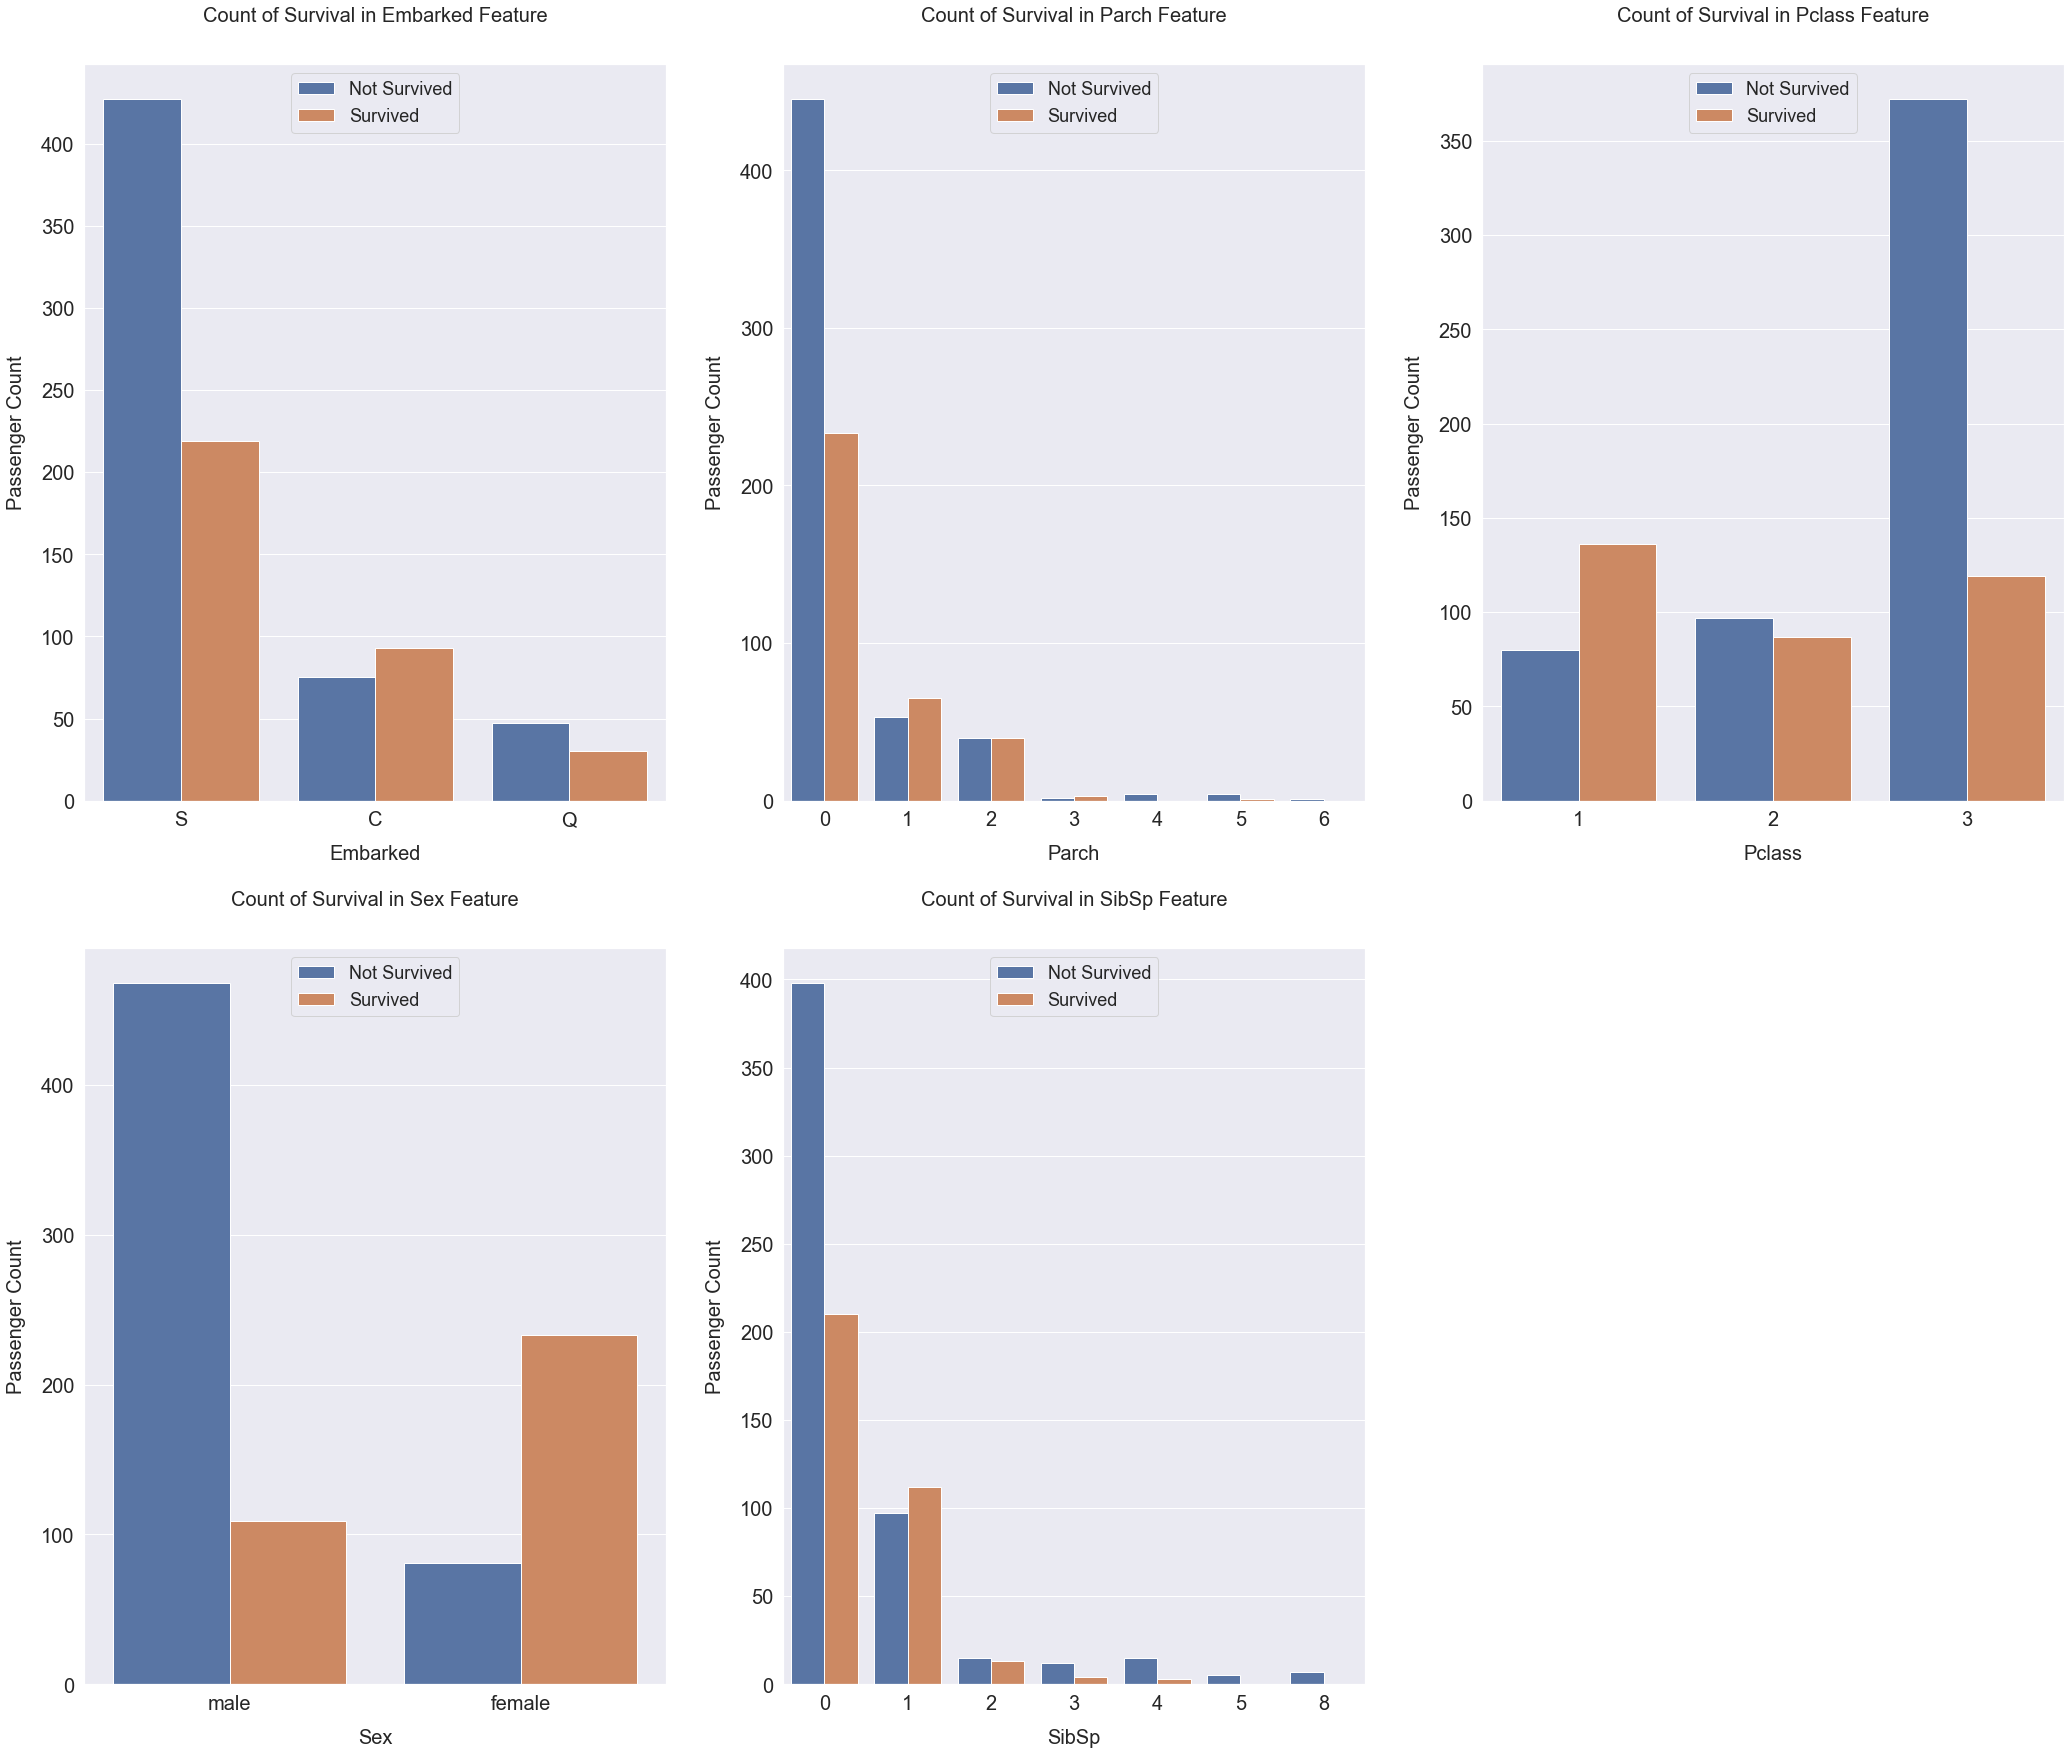

In [21]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp',]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=train_data)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

# 2 Feature Engineering

Fare and Age are to be binned to handle data outliers

In [22]:
aux_data = train_data.copy()
aux_data['Fare'] = pd.qcut(aux_data['Fare'], 15)

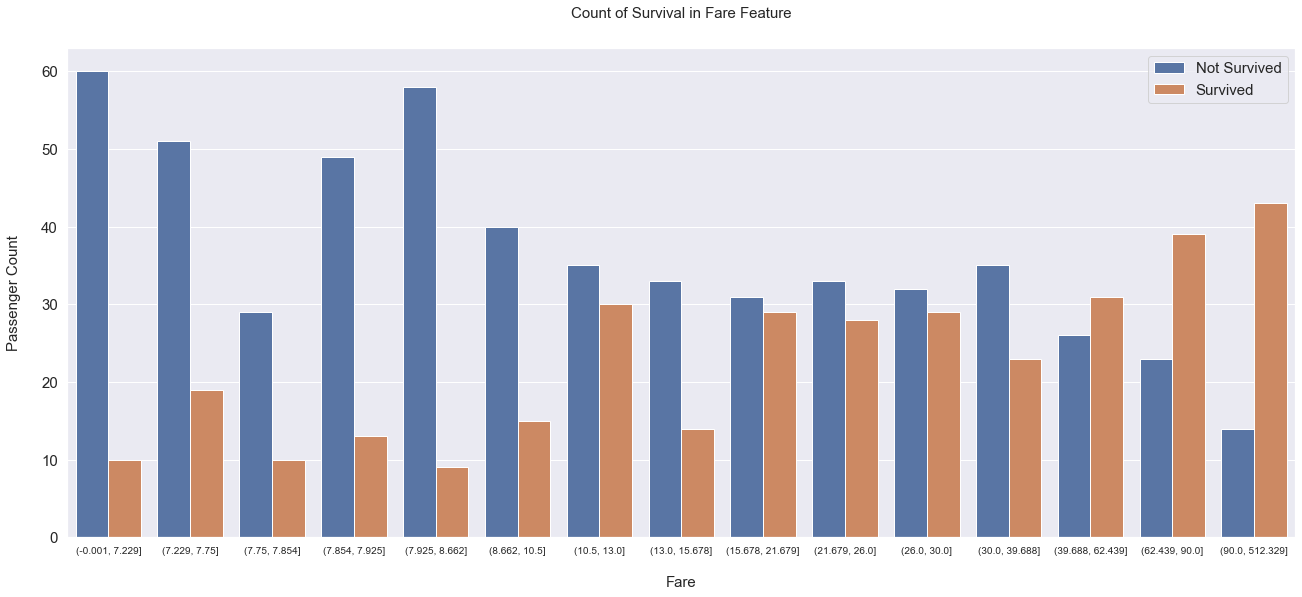

In [23]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=aux_data)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

In [24]:
aux_data['Age'] = pd.qcut(aux_data['Age'], 10)

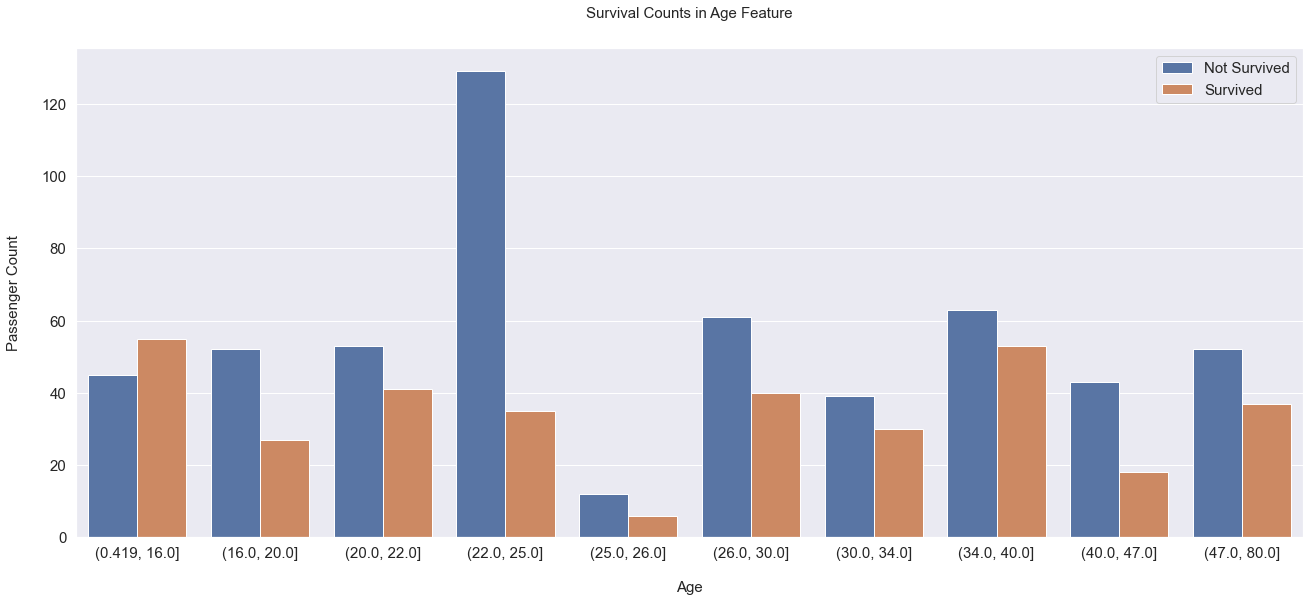

In [25]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=aux_data)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

In [26]:
def bin_fare(X):
    X['Fare'] = pd.qcut(X['Fare'], 13)
    return X

def bin_age(X):
    X['Age'] = pd.qcut(X['Age'], 10)
    return X

def compute_family_size(X):
    X['Family_Size'] = X['SibSp'] + X['Parch'] + 1
    return X

def add_title(X):
    X['Title'] = X['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    X['Title'] = X['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
    X['Title'] = X['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')
    return X

def add_deck(X):
    try:
        X['Deck'] = X['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')
        # Passenger in the T deck is changed to A
        idx = X[X['Deck'] == 'T'].index
        X.loc[idx, 'Deck'] = 'A'
    except:
        pass
    return X

def delete_dublicated_info(X):
    try:
        X = X.drop(['Cabin'], axis=1)
    except:
        pass
    try:
        X = X.drop(['PassengerId'], axis=1)
    except:
        pass
    try:
        X = X.drop(['SibSp'], axis=1)
    except:
        pass
    try:
        X = X.drop(['Parch'], axis=1)
    except:
        pass
    try:
        X = X.drop(['Name'], axis=1)
    except:
        pass
    return X

def delete_unnecessary_info(X):
    try:
        X = X.drop(['Ticket'], axis=1)
    except:
        pass
    try:
        X = X.drop(['Survived'], axis=1)
    except:
        pass
    return X

def convert_to_dense(X):
    try:
        return X.todense()
    except:
        return X

Feature transformation is performed with LabelEncoding if features are non-numerical and One-Hot if they are categorial

In [27]:
feature_engineering_pipeline = Pipeline([
    ("add_deck",  FunctionTransformer(add_deck)),
    ("bin_fare",  FunctionTransformer(bin_fare)),
    ("bin_age",  FunctionTransformer(bin_age)),
    ("compute_family_size",  FunctionTransformer(compute_family_size)),
    ("add_title",  FunctionTransformer(add_title)),
    ("delete_dublicated_info",  FunctionTransformer(delete_dublicated_info)),
    ("delete_unnecessary_info",  FunctionTransformer(delete_unnecessary_info)),
    ("encode", OneHotEncoder(handle_unknown="ignore")),
    ("convert_to_dense",  FunctionTransformer(convert_to_dense)),
    ("scale", MinMaxScaler())
    ])

In [28]:
merged_pipeline = Pipeline([  
    ("missing_values_pipeline",  missing_values_pipeline),
    ("feature_engineering_pipeline",  feature_engineering_pipeline)
    ])

In [29]:
all_data = merged_pipeline.fit_transform(all_data)
X_train = all_data[:891]
X_test = all_data[891:]

# 3 Model

In [30]:
param_dist = [
    {'booster ': ["gbtree", "dart"], 
     'eta ': reciprocal(0.01, 1),
     "gamma ": reciprocal(0.01, 50),
     "max_depth ": randint(1, 20),
    'min_child_weight': randint(1, 15),
    'max_delta_step': randint(1, 15),
    'lambda':reciprocal(0.01, 10)},

    {'booster ': ["gbtree", "dart"], 
     'eta ': reciprocal(0.01, 1),
     "gamma ": reciprocal(0.01, 50),
     "max_depth ": randint(1, 20),
    'min_child_weight': randint(1, 15),
    'max_delta_step': randint(1, 15),
    'lambda':[0],
    'alpha':reciprocal(0.01, 10)},
    
    {'booster ': ["gbtree", "dart"], 
     'eta ': reciprocal(0.01, 1),
     "gamma ": reciprocal(0.01, 50),
     "max_depth ": randint(1, 20),
    'min_child_weight': randint(1, 15),
    'max_delta_step': randint(1, 15),
    'alpha':reciprocal(0.01, 10),
    'lambda':reciprocal(0.01, 10)},
    
]

xgb_model = xgboost.XGBRFClassifier(random_state=42).fit(
    X_train, y_train)
rnd_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist,
                                n_iter=2000, cv=5, scoring='accuracy',
                                verbose=2, n_jobs=-1, return_train_score=True)

rnd_search.fit(X_train, y_train)

[18:19:02] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 5 folds for each of 2000 candidates, totalling 10000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done 341 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 989 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 1434 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 1961 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 2568 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 3257 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 4877 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 5808 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 6821 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 7914 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done 9089 tasks      | 

[18:25:54] WARNING: ..\src\learner.cc:541: 
Parameters: { booster , eta , gamma , max_depth  } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:25:54] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=XGBRFClassifier(base_score=0.5, booster='gbtree',
                                             colsample_bylevel=1,
                                             colsample_bytree=1, gamma=0,
                                             gpu_id=-1, importance_type='gain',
                                             interaction_constraints='',
                                             max_delta_step=0, max_depth=6,
                                             min_child_weight=1, missing=nan,
                                             monotone_constraints='()',
                                             n_estimators=100, n_jobs=12,
                                             num_parallel_tree=100,
                                             objective='binary:logistic...
                                         'lambda': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000015F02F2CB50>,
                                 

In [31]:
rnd_search.best_params_

{'alpha': 0.2863131273768466,
 'booster ': 'gbtree',
 'eta ': 0.20133650202440462,
 'gamma ': 0.06754068307719534,
 'lambda': 0,
 'max_delta_step': 1,
 'max_depth ': 4,
 'min_child_weight': 1}

In [32]:
rnd_search.best_score_

0.8350323269097985

In [33]:
rnd_best = rnd_search.best_params_

In [34]:
cvres = rnd_search.cv_results_
for mean_test_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_test_score, params)

0.7969116816270165 {'alpha': 2.452612631133676, 'booster ': 'gbtree', 'eta ': 0.2910635913133069, 'gamma ': 1.638399383528232, 'lambda': 0.02938027938703535, 'max_delta_step': 3, 'max_depth ': 11, 'min_child_weight': 11}
0.7744397715146569 {'booster ': 'dart', 'eta ': 0.01930783753654713, 'gamma ': 2.5563301227559907, 'lambda': 0.014765043713594344, 'max_delta_step': 8, 'max_depth ': 12, 'min_child_weight': 14}
0.8125918021467579 {'alpha': 0.010053940194693016, 'booster ': 'dart', 'eta ': 0.023270677083837798, 'gamma ': 0.1334697757417809, 'lambda': 0, 'max_delta_step': 6, 'max_depth ': 12, 'min_child_weight': 9}
0.7744397715146569 {'booster ': 'gbtree', 'eta ': 0.16738085788752124, 'gamma ': 0.032808290847300484, 'lambda': 0.07523742884534855, 'max_delta_step': 14, 'max_depth ': 15, 'min_child_weight': 14}
0.8148264390182665 {'alpha': 0.14040609919104427, 'booster ': 'dart', 'eta ': 0.1530485212183146, 'gamma ': 0.01485315398042161, 'lambda': 0.6647135865318025, 'max_delta_step': 5, '

0.8170610758897748 {'alpha': 0.9254657897108173, 'booster ': 'gbtree', 'eta ': 0.12180994543963954, 'gamma ': 0.9102050033340152, 'lambda': 0.11048677390131482, 'max_delta_step': 6, 'max_depth ': 1, 'min_child_weight': 3}
0.7969116816270165 {'alpha': 0.1799240073273079, 'booster ': 'gbtree', 'eta ': 0.3203450289032646, 'gamma ': 11.098034061187677, 'lambda': 4.347013409798409, 'max_delta_step': 9, 'max_depth ': 15, 'min_child_weight': 11}
0.8237963718536188 {'booster ': 'dart', 'eta ': 0.19076637619352732, 'gamma ': 17.61190703239436, 'lambda': 0.17963658876905517, 'max_delta_step': 5, 'max_depth ': 1, 'min_child_weight': 2}
0.7744397715146569 {'alpha': 5.112460212952254, 'booster ': 'dart', 'eta ': 0.7957185873733645, 'gamma ': 35.06108620941533, 'lambda': 0, 'max_delta_step': 11, 'max_depth ': 15, 'min_child_weight': 14}
0.8181721172556651 {'booster ': 'gbtree', 'eta ': 0.9818057398797934, 'gamma ': 0.04632476049465715, 'lambda': 0.3218420754326147, 'max_delta_step': 3, 'max_depth ':

In [35]:
final_model = rnd_search.best_estimator_
y_train_pred = final_model.predict(X_train)
y_train_pred_proba = final_model.predict_proba(X_train)

# 4 Feature importances

In [36]:
feature_importances = final_model.feature_importances_

In [37]:
cat_one_hot_attribs = list(merged_pipeline["feature_engineering_pipeline"]["encode"].categories_)
cat_one_hot_attribs = list(itertools.chain(*cat_one_hot_attribs))

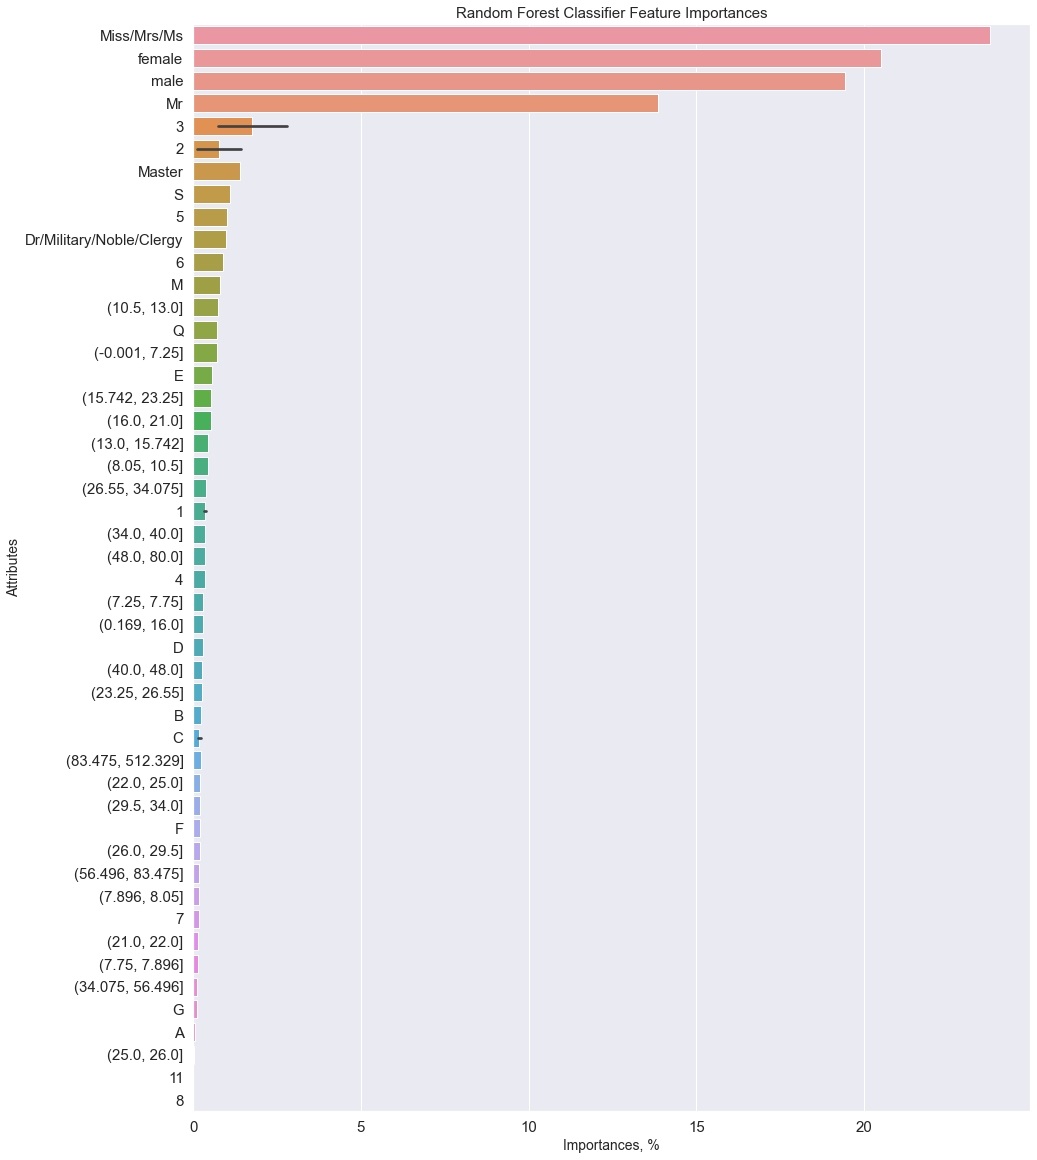

In [38]:
sorted_feature_importances = sorted(zip(feature_importances*100, cat_one_hot_attribs), reverse=True)
sorted_feature_importances = pd.DataFrame (sorted_feature_importances, columns=['Importances', 'Attributes'])

plt.figure(figsize=(15, 20))
sns.barplot(x='Importances', y='Attributes', data=sorted_feature_importances)

plt.xlabel('Importances, %')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Feature Importances', size=15)

plt.show()

# 5 PR and ROC Curves

In [39]:
precisions, recalls, thresholds = precision_recall_curve(y_train, y_train_pred_proba[:,1])
f1 = f1_score(y_train, y_train_pred)
f1

0.812199036918138

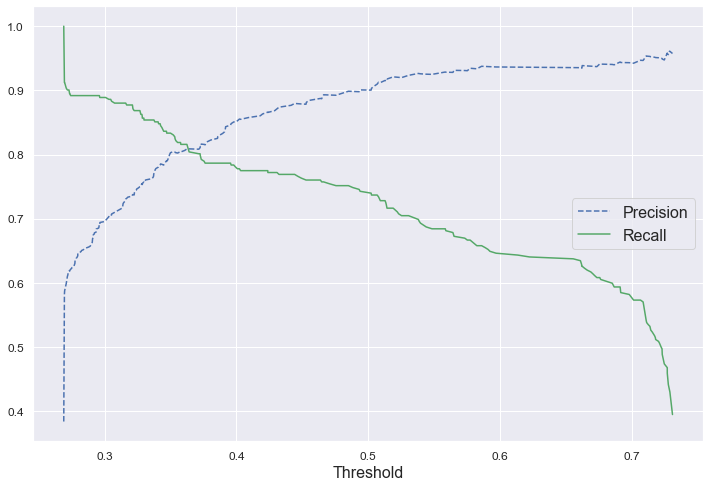

In [40]:
def plot_precision_recall_vs_threshold (precisions, recalls, thresholds): 
    plt.plot(thresholds, precisions[:-1], "b--" , label = "Precision") 
    plt.plot(thresholds, recalls[:-1], "g-" , label = "Recall")
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True) 
    
plt.figure(figsize=(12, 8))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)                                                                       
plt.show()

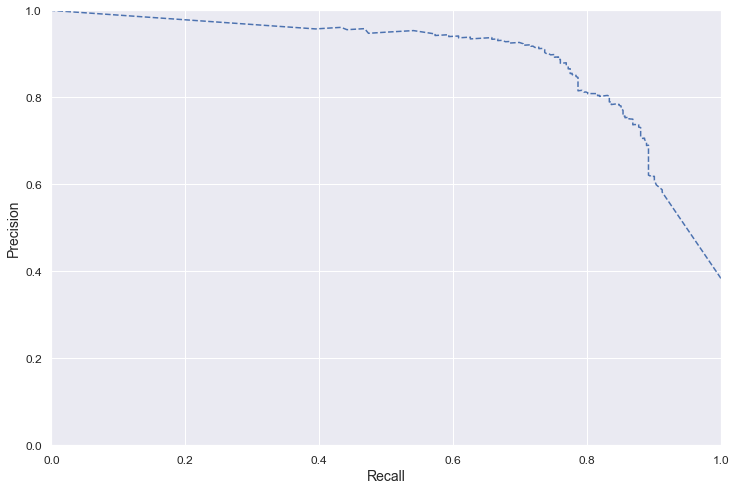

In [41]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b--", label = "PrecisionVSRecall")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plt.figure(figsize=(12, 8))
plot_precision_vs_recall(precisions, recalls)
plt.show()

In [42]:
fpr, tpr, thresholds = roc_curve(y_train, final_model.predict_proba(X_train)[:, 1])
auc_score = auc(fpr, tpr)

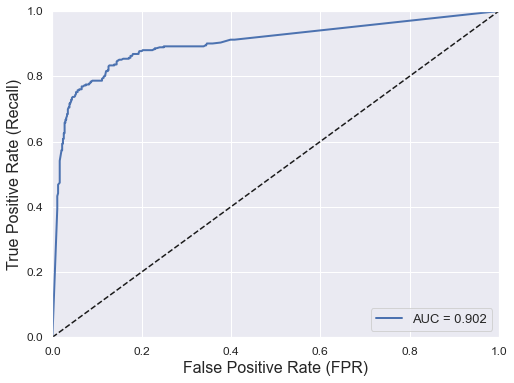

In [43]:
def plot_roc_curve (fpr, tpr, label = None): 
    plt.plot(fpr, tpr, linewidth = 2, label = label) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])                                    
    plt.xlabel('False Positive Rate (FPR)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr,tpr, label='AUC = {:.3f}'.format(auc_score))
plt.legend(loc='lower right', prop={'size': 13})
plt.show()

# 6 Results for submission

In [44]:
y_on_test_data = final_model.predict(X_test)

In [45]:
data_to_write = pd.read_csv("datasets/titanic/test.csv")
data_to_write["Survived"] = y_on_test_data
data_to_write = data_to_write[["PassengerId", "Survived"]]
data_to_write.to_csv('datasets/titanic/titanic_survived.csv', index=False)